# Unsupervised Modeling of Reviews
<p style='color:navy'><b>
    In this section, we ignore the <i> A Priori</i> classes that our review dataset belongs to and 
    created two unsupervised models - LDA and NMF - and see how the clusters we generated compare 
    to the classes the data belongs to.
</b></p>

## Table of Contents
<ol>
    <li>Packages</li>
    <li>Parquet Ingestion</li>
    <li>Recyclable Functionality</li>
    <li><b>NMF</b> - Non-negative matrix factorization</li>
    <li><b>NMF</b> - Full Text</li>
    <li><b>NMF</b> - Adjectives/Verbs </li>
    <li><b>NMF</b> - Adjectives/Nouns</li>
    <li><b>LDA</b> - Latent Dirichlet Allocation</li>
    <li><b>LDA</b> - Full Text</li>
    <li><b>LDA</b> - Adjectives/Verbs </li>
    <li><b>LDA</b> - Adjectives/Nouns</li>
    <li><b>LDA</b> - Visualization and Comparrison with Apriori Groups</li>
    <li>Closing Remarks</li>
</ol>

### Packages

In [1]:
import pandas as pd 
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.decomposition import NMF
from collections import Counter, defaultdict
import warnings #turn off warnings
warnings.filterwarnings("ignore", category=UserWarning) 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

#GENSIM MODELING - LDA AND NMF
from gensim.models.nmf import Nmf
from gensim.models import LdaModel
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from IPython.display import Image

### Parquet Ingestion

In [44]:
df = pd.read_parquet('prepared_text.parquet.gzip')

In [45]:
df = df.rename({"new_reviews":"text"},axis=1)
df.sample(3)

,Rating,lemmas,adjs_verbs,nouns,noun_phrases,adj_noun_phrases,entities,tokens,token_count,text
111155,1,"[keep, freeze, keep, glitching, suppose, chris...","[keep, freeze, keep, suppose, happy]","[glitching, christmas, gift, wife]",[gift_wife],[],[],"[keeps, freezing, keeps, glitching, suppose, c...",10,keeps freezing keeps glitching suppose christm...
374738,4,"[buy, phone, last, month, honest, first, exper...","[buy, honest, take, familiar, android, operatt...","[phone, month, experience, smartphone, day, op...",[experience_smartphone],"[last_month, first_experience, first_experienc...",[],"[bought, phone, last, month, honest, first, ex...",21,bought phone last month honest first experienc...
229087,3,"[buy, husband, week, thus, far, like, shall, s...","[buy, come, hold]","[husband, week, like, day, rereview]",[husband_week],[],[],"[bought, husband, week, thus, far, likes, shal...",12,bought husband week thus far likes shall see d...


as a result of our data cleaning pipeline, much of the groundwork needed for unsupervised analysis has already been laid out for us, primarily in the realm of tokenization. Based on the performance of our LDA and NMF models, we may consider modifying the text we pass to either model by omitting certain parts of speech or entities to improve model performance. 

### Creating Recyclable Functionality for Modeling
this notebook utilizes the **Gensim** library for modeling LDA and NMF. We can reduce the number of lines of code we write significantly by making this process general-form and creating a function that takes in a data series and prints out topics and their coherence scores. **This also gives us the benefit of having real-time evaluation of model performance.**

In [36]:
def display_topics_gensim(model):
    for topic in range(0, model.num_topics):
        print("\nTopic %02d" % topic)
        for (word, prob) in model.show_topic(topic, topn=5):
            print("  %s (%2.2f)" % (word, prob))

In [82]:
def get_model_gensim(tokens,model_type,topics=5):
    
    if model_type not in ['LDA','NMF']:
        print('Not a model - please select from LDA or NMF.')
        return
    
    #data prep
    dict_gensim = Dictionary(tokens)
    dict_gensim.filter_extremes(no_below=5, no_above=0.7)
    bow_gensim = [dict_gensim.doc2bow(t) for t in tokens]

    #init placeholder for model
    this_model = None
    
    if model_type == 'LDA':
        this_model = LdaModel(
            corpus=bow_gensim, 
            id2word=dict_gensim,
            chunksize=2000, 
            alpha='auto', 
            eta='auto', 
            iterations=400, 
            num_topics=topics,
            passes=20, 
            eval_every=None, 
            random_state=42
        )
        
    if model_type == 'NMF':
        #conduct a TF-IDF transformation for NMF
        tfidf_gensim = TfidfModel(bow_gensim)
        vectors_gensim = tfidf_gensim[bow_gensim]
        
        #run model
        this_model = Nmf(
            vectors_gensim, 
            num_topics=topics,
            id2word=dict_gensim, 
            kappa=0.1, 
            eval_every=5
        )
        
    #print out topic words
    print(f'Topics for {model_type}')
    display_topics_gensim(this_model)

    #print out coherence score
    score = CoherenceModel(
        model=this_model,
        texts=tokens, 
        dictionary=dict_gensim, 
        coherence='u_mass'
    )
    this_coh_score = score.get_coherence()
    print(f'Coherence score for {model_type}: {this_coh_score}')
    
    return (this_model)


### Nonnegative Matrix Factorization (NMF) with Gensim
The easiest way to find a latent structure in a doc matrix is by factorizing it and seeing what's left over. Because a TFIDF matrix always has positive values, we can represent a document matrix as the product of two smaller matrices: V = W * H, where **W has the same number of rows as V and represent the topic mapping for each document, and H shows how the topics are constituted of features.**

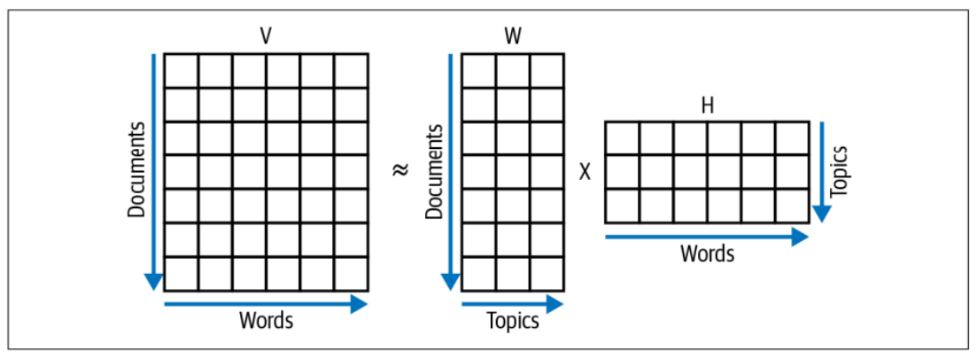

In [2]:
Image(filename='nmf.jpg') 

we begin by running an NMF analysis for four different types of data - the full review text, only the verb-adjectives, adjective_nouns, and then a combination of the latter two.

### NMF With Full Text

In [48]:
get_model_gensim(df['tokens'],'NMF')

Topics for NMF

Topic 00
  like (0.03)
  price (0.02)
  work (0.01)
  thanks (0.01)
  awesome (0.01)

Topic 01
  excellent (0.13)
  product (0.08)
  perfect (0.06)
  nice (0.05)
  ok (0.03)

Topic 02
  good (0.71)
  far (0.01)
  condition (0.01)
  phone (0.01)
  quality (0.01)

Topic 03
  great (0.30)
  love (0.14)
  works (0.11)
  phone (0.05)
  condition (0.03)

Topic 04
  phone (0.01)
  excelente (0.01)
  new (0.01)
  one (0.01)
  battery (0.01)
Coherence score for NMF: -3.955640379099367


### NMF With Verbs/Adjectives only

In [49]:
get_model_gensim(df['adjs_verbs'],'NMF')

Topics for NMF

Topic 00
  good (0.69)
  love (0.08)
  nice (0.02)
  low (0.01)
  fast (0.00)

Topic 01
  good (0.91)
  recommend (0.01)
  thank (0.00)
  slow (0.00)
  overall (0.00)

Topic 02
  new (0.02)
  buy (0.02)
  perfect (0.02)
  love (0.02)
  come (0.01)

Topic 03
  great (0.42)
  work (0.22)
  fast (0.01)
  awesome (0.01)
  easy (0.01)

Topic 04
  excellent (0.61)
  nice (0.03)
  recommend (0.02)
  thank (0.01)
  fast (0.00)
Coherence score for NMF: -4.730610952079627


### NMF With Adjectives/Noun Phrases Only

In [51]:
get_model_gensim(df['adj_noun_phrases'],'NMF')

Topics for NMF

Topic 00
  good_condition (0.10)
  great_product (0.07)
  good_product (0.04)
  excellent_product (0.04)
  excellent_condition (0.03)

Topic 01
  good_phone (0.23)
  good_phone_price (0.01)
  easy_use (0.00)
  perfect_condition (0.00)
  excellent_phone (0.00)

Topic 02
  great_phone (0.23)
  great_phone_price (0.01)
  great_phone_love (0.01)
  excellent_phone (0.00)
  easy_use (0.00)

Topic 03
  sim_card (0.09)
  new_phone (0.08)
  easy_use (0.00)
  unlocked_phone (0.00)
  sim_card_phone (0.00)

Topic 04
  nice_phone (0.12)
  great_condition (0.05)
  great_price (0.05)
  excellent_product (0.02)
  excellent_phone (0.01)
Coherence score for NMF: -6.638012922890771


### NMF With Verbs/Adjs + Adjs/Nouns Phrases

In [60]:
adj_noun_verbs = df.apply(lambda x: (x.adj_noun_phrases.tolist() + x.adjs_verbs.tolist()) , axis=1)
get_model_gensim(adj_noun_verbs,'NMF')

Topics for NMF

Topic 00
  excellent (0.43)
  excellent_product (0.05)
  excellent_phone (0.02)
  excellent_condition (0.01)
  recommend (0.01)

Topic 01
  love (0.16)
  buy (0.05)
  nice (0.05)
  perfect (0.02)
  nice_phone (0.02)

Topic 02
  great (0.19)
  work (0.18)
  great_phone (0.07)
  great_product (0.02)
  great_price (0.01)

Topic 03
  new (0.02)
  come (0.01)
  get (0.01)
  happy (0.01)
  look (0.01)

Topic 04
  good (0.37)
  good_phone (0.05)
  good_product (0.02)
  good_price (0.01)
  good_condition (0.01)
Coherence score for NMF: -5.281283329510645


#### Final Remarks on NMF:
The best performing model was the full-text NMF with a score of -3.9, which is the highest out of all possible variants.

### Latent Dirichlet Allocation
LDA views each document as consisting of different topics. In other words, each
document is a mix of different topics. In the same way, topics are mixed from words.
To keep the number of topics per document low and to have only a few, important
words constituting the topics, LDA initially uses a Dirichlet distribution, a so-called
Dirichlet prior. This is applied both for assigning topics to documents and for finding
words for the topics. The Dirichlet distribution ensures that documents have only a
small number of topics and topics are mainly defined by a small number of words.

#### Note:
**Because C_V is far too slow as a coherence score generation mechanism, we use u_mass instead. For this type of coherence score, low negative values are associated with success.**

### Approach: Using LDA with Gensim - Full Text (Best Performance)

In [67]:
lda_mod = get_model_gensim(df['tokens'],'LDA')

Topics for LDA

Topic 00
  phone (0.13)
  great (0.07)
  good (0.07)
  works (0.04)
  love (0.03)

Topic 01
  camera (0.02)
  screen (0.01)
  like (0.01)
  samsung (0.01)
  sony (0.01)

Topic 02
  phone (0.08)
  one (0.02)
  would (0.01)
  get (0.01)
  work (0.01)

Topic 03
  sim (0.06)
  card (0.05)
  unlocked (0.03)
  att (0.03)
  verizon (0.02)

Topic 04
  battery (0.07)
  life (0.02)
  charge (0.02)
  day (0.02)
  sound (0.01)
Coherence score for LDA: -2.2296787912602896


### Approach: Using LDA with Gensim - Verbs/Adjs

In [62]:
get_model_gensim(df['adjs_verbs'],'LDA')

Topics for LDA

Topic 00
  look (0.03)
  want (0.03)
  use (0.02)
  need (0.02)
  find (0.02)

Topic 01
  awesome (0.04)
  arrive (0.04)
  include (0.03)
  lte (0.02)
  original (0.02)

Topic 02
  good (0.30)
  nice (0.08)
  love (0.07)
  recommend (0.06)
  happy (0.05)

Topic 03
  great (0.33)
  work (0.28)
  expect (0.06)
  fast (0.06)
  fine (0.04)

Topic 04
  buy (0.06)
  get (0.05)
  come (0.04)
  new (0.04)
  excellent (0.03)
Coherence score for LDA: -3.494048601109698


### Approach: Using LDA with Gensim - Nouns/Adjs

In [63]:
get_model_gensim(df['adj_noun_phrases'],'LDA')

Topics for LDA

Topic 00
  great_phone (0.08)
  sim_card (0.04)
  nice_phone (0.03)
  unlocked_phone (0.02)
  old_phone (0.02)

Topic 01
  excellent_phone (0.02)
  dual_sim (0.02)
  great_price (0.02)
  good_price (0.01)
  long_time (0.01)

Topic 02
  new_phone (0.07)
  basic_phone (0.02)
  international_version (0.02)
  awesome_phone (0.02)
  good_condition (0.02)

Topic 03
  easy_use (0.03)
  android_phone (0.02)
  great_product (0.02)
  happy_phone (0.02)
  well_phone (0.01)

Topic 04
  good_phone (0.10)
  smart_phone (0.04)
  excellent_product (0.02)
  good_quality (0.01)
  happy_purchase (0.01)
Coherence score for LDA: -6.589716739801671


### Visualization - LDA with Full text

In [68]:
from sklearn.feature_extraction.text import CountVectorizer
count_para_vectorizer = CountVectorizer(
    stop_words=stopwords, 
    min_df=5,
    max_df=0.7
)
count_para_vectors = count_para_vectorizer.fit_transform(df["text"])

In [72]:
import pyLDAvis.sklearn
lda_mod = LatentDirichletAllocation(n_components = 5, random_state=42)
W_lda_para_matrix = lda_mod.fit_transform(count_para_vectors)
H_lda_para_matrix = lda_mod.components_

lda_display = pyLDAvis.sklearn.prepare(
    lda_mod, 
    count_para_vectors,
    count_para_vectorizer, 
    sort_topics=False
)
pyLDAvis.display(lda_display)

#### Comparrison with Apriori Group Topic generation

In [92]:
for rating in sorted(df['Rating'].unique()):
    this_rating = df.query(f"Rating=={rating}")
    print(f'TOPIC/RATING: {rating} N = {len(this_rating)}')
    get_model_gensim(this_rating['tokens'],'LDA',topics=1)
    print('-----------------\n\n')

TOPIC/RATING: 1 N = 71375
Topics for LDA

Topic 00
  phone (0.06)
  work (0.01)
  one (0.01)
  would (0.01)
  screen (0.01)
Coherence score for LDA: -1.8808731546856088
-----------------


TOPIC/RATING: 2 N = 24534
Topics for LDA

Topic 00
  phone (0.05)
  battery (0.01)
  one (0.01)
  screen (0.01)
  would (0.01)
Coherence score for LDA: -1.6476912049801582
-----------------


TOPIC/RATING: 3 N = 31384
Topics for LDA

Topic 00
  phone (0.05)
  good (0.01)
  like (0.01)
  one (0.01)
  battery (0.01)
Coherence score for LDA: -1.6983812754312848
-----------------


TOPIC/RATING: 4 N = 60204
Topics for LDA

Topic 00
  phone (0.05)
  good (0.02)
  great (0.01)
  like (0.01)
  use (0.01)
Coherence score for LDA: -1.6622381308614727
-----------------


TOPIC/RATING: 5 N = 218172
Topics for LDA

Topic 00
  phone (0.05)
  great (0.02)
  good (0.01)
  love (0.01)
  one (0.01)
Coherence score for LDA: -1.9176512099948588
-----------------




### Closing Remarks

Overall, our LDA models seem to outperform our NMF models, all else held constant. The LDA that uses the full text has the strongest coherence score out of all candidates. With regards to the visualization from ```pyLDAvis```, we observe that topics 1 and 3 have considerable overlap among one another, primarily because they both make strong references to actual features of the phones they review. There is a strong tapering-off for both topics, so they seem well defined.

Topic 2 is largely characterized by refrences to the word 'phone', which isn't particularly meaningful to us since all of these reviews are about phones, but separates itself by possibly containing reviews that mention phones but not their individual features as part of the review.

Topic 5 is poorly defined and small, with no meaningful insights.

Topic 4, however, **is driven by a meaningful combination of sentiment and product descriptions.** This topic is driven by one noun (phone), followed by several adjectives (good, great, excellent), which sends the impression that Topic 4 is comprised largely of positive reviews that don't get specific about technical features.

##### Remarks on Apriori Groups
The general trend in apriori groups is that lower rating values (particular 1 and 2) tend to not include any positive adjectives, but also tend to excluse negative adjectives and simply discuss the product. Insofar as this is the case, Topics 5 and 2 correspond to negative reviews, while 1,3, and 4 correspond to positive reviews, but it's unclear to which respective ranking. We can speculate that Topic 4, which contains the strongest use of positive adjectives, may correspond to a rating of 5.